In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
import numpy as np

In [2]:
config = {
    "recovery_time": 3,
    "transmission_probability": 0.8,
    "death_rate": 0.1,
}

In [3]:
class Agent:
    statuses = ["healthy", "sick", "recovered", "dead"]
    
    def __init__(self, index = None, status=statuses[0]):
        self.index = index
        self.status = status
        self.infection_time = 0
        
    def __str__(self):
        return self.status
    
    def __repr__(self):
        return self.__str__()
    
    def interact(self, other_status):
        if self.status == "healthy" and other_status == "sick":
            p = np.random.random()
            if p < config["transmission_probability"]:
                self.status = "sick"
    
    def step(self):
        if self.status == "sick":
            self.infection_time += 1
            if self.infection_time > config["recovery_time"]:
                self.status = "recovered"
            p = np.random.random()
            if p < config["death_rate"]:
                self.status = "dead"        

In [4]:
def random_pairs(pop): #takes list of length N and returns floor(N/2) random pairs of indices 
    size = len(pop)
    halfway = int(np.floor(size/2))
    indices = np.array([i for i in range(size)])
    
    np.random.shuffle(indices)
    partition_1 = indices[0 : halfway]
    partition_2 = indices[halfway : size]
    
    lineup = np.stack([partition_1, partition_2])
    
    pairs = np.transpose(lineup)  
        
    return pairs

def infection_step(population, distancing_factor=1):
    pairs = random_pairs(population)
    
    for pair in pairs:
        n = np.random.random()
        if n < distancing_factor:    # social distancing factor, 0 = total isolation, 1 = no distancing
            agentA = population[pair[0]]
            agentB = population[pair[1]]
            
            population[pair[0]].interact(agentB.status)
            population[pair[1]].interact(agentA.status)
            
            for i in range(2):
                population[pair[i]].step()
        
    return population

In [5]:
def simulate_pandemic(population_size=200, step_count=60, distancing_factor=0.5, df2 = None, t_d = None): # returns sick, recovered, dead in [0, 1]
    td = (step_count + 1) if (t_d == None) else t_d
    df2 = distancing_factor if (df2 == None) else df2
    
    population = np.array([Agent() for _ in range(population_size)])
    population[0].status = "sick"  # patient zero

    sick = np.array([1])
    recovered = np.array([0])
    dead = np.array([0])

    for i in range(step_count):
        if i > td:
            distancing_factor = df2
        
        infection_step(population, distancing_factor=distancing_factor)
        stats = {"healthy": 0, "sick": 0, "recovered": 0, "dead": 0}
        for a in population:
            stats[a.status] += 1
            
        sick = np.append(sick, stats['sick'])
        recovered = np.append(recovered, stats['recovered'])
        dead = np.append(dead, stats['dead'])

    x = [i for i in range(step_count + 1)]

    sick = sick/float(population_size)
    recovered = recovered/float(population_size)
    dead = dead/float(population_size)
    
    return [x, sick, recovered, dead]

In [6]:
cm = get_cmap("twilight")
colors = [cm(i/4.0) for i in range(4)]

In [9]:
steps = 60
size = 600
stats_00 = simulate_pandemic(population_size=size, step_count=steps, distancing_factor=0.2)
stats_01 = simulate_pandemic(population_size=size, step_count=steps, distancing_factor=0.5)
stats_10 = simulate_pandemic(population_size=size, step_count=steps, distancing_factor=0.8)
stats_11 = simulate_pandemic(population_size=size, step_count=steps, distancing_factor=0.8, df2=0.2, t_d=10)

stat_matrix = [[stats_00, stats_01], [stats_10, stats_11]]

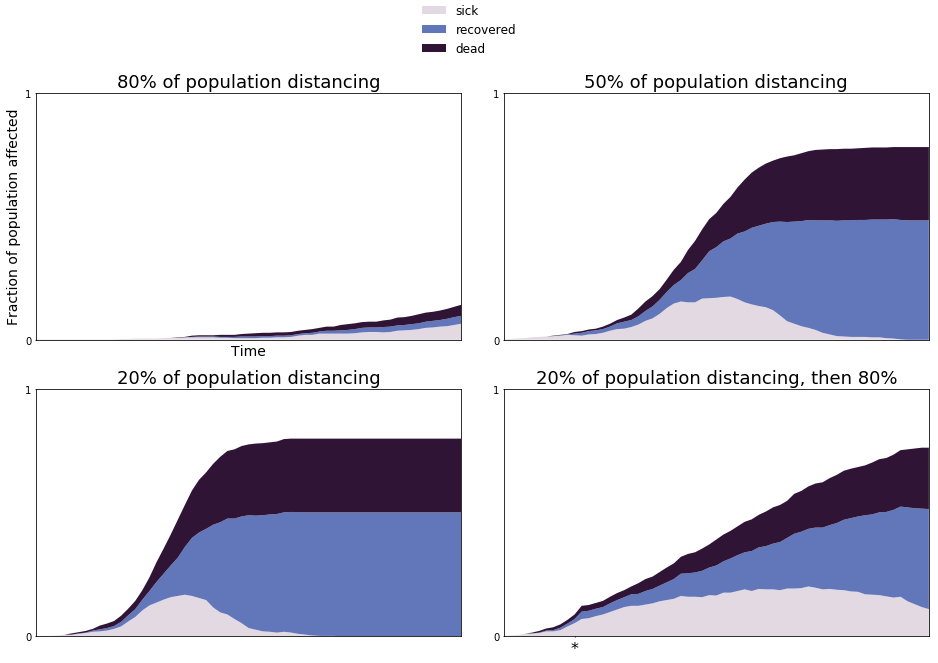

In [14]:
fig, axes = plt.subplots(2,2, figsize=(16, 10), gridspec_kw={"wspace":0.1})

for i in range(2):
    for j in range(2):
        axes[i][j].stackplot(stat_matrix[i][j][0], stat_matrix[i][j][1:], labels=Agent.statuses[1:], colors=colors)
        
        axes[i][j].tick_params(length=1)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([0, 1])
        axes[i][j].set_ylim((0, 1))
        axes[i][j].set_xlim((0, len(stat_matrix[0][0][0])-1))

axes[0][0].set_title("80% of population distancing", fontsize=18)
axes[0][0].set_xlabel("Time", fontsize=14)
axes[0][0].set_ylabel("Fraction of population affected", fontsize=14)
axes[0][1].set_title("50% of population distancing", fontsize=18)
axes[1][0].set_title("20% of population distancing", fontsize=18)
axes[1][1].set_title("20% of population distancing, then 80%", fontsize=18)
axes[1][1].set_xticks([10])
axes[1][1].set_xticklabels(["*"], fontdict={"fontsize": 16})
fig.legend(labels=Agent.statuses[1:], edgecolor='white', fontsize=12, loc='upper center', borderaxespad=0)

In [16]:
fig.savefig("Pandemic.png")